# Orbit Transfer Problem
## Fixed Time, max the new radius

https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_bvp.html

In [1]:
from os.path import exists
file_exists = exists('basic_material.py')

if (not file_exists):
    !wget -O basic_material.py https://www.dropbox.com/s/o48uhuwah8n2xww/basic_material.py?dl=0
%run basic_material

from scipy.integrate import solve_bvp, solve_ivp
from scipy.interpolate import interp1d

Running Python: 3.9.9


In [2]:
Tf = 5
N = 1000
t = np.linspace(0, Tf, N)
R0 = 1  # initial radius
Mu = 1  # orbit param
m0 = 1  # initial fuel
m1 = -0.07485 # fuel descrease rate
print(f'Initial Mass = {m0 :0.3f}')
print(f'Final Mass = {m0 + m1*Tf:0.3f}')
T = 0.1405    # thrust

Initial Mass = 1.000
Final Mass = 0.626


In [3]:
def bc(ya, yb):
    r0 = ya[0]
    u0 = ya[1]
    v0 = ya[2]
    lamr0 = ya[3]
    lamu0 = ya[4]
    lamv0 = ya[5]

    rf = yb[0]
    uf = yb[1]
    vf = yb[2]
    lamrf = yb[3]
    lamuf = yb[4]
    lamvf = yb[5]
    
    if (rf < 0):
        print(rf)

    b1 = r0 - R0
    b2 = u0
    b3 = v0 - np.sqrt(Mu/R0)
    b4 = uf
    b5 = vf - np.sqrt(Mu/rf)
    b6 = lamrf + 1 - lamvf*np.sqrt(Mu)/2/rf**(3/2)

    return np.array([b1,b2,b3,b4,b5,b6])

def fun(t,xv):
    r = xv[0]
    u = xv[1]
    v = xv[2]
    lamr = xv[3]
    lamu = xv[4]
    lamv = xv[5]
    
    sinphi = -lamu/np.sqrt(lamu**2+lamv**2)
    cosphi = -lamv/np.sqrt(lamu**2+lamv**2)

    dr = u
    du = v**2/r - Mu/r**2 + T*sinphi/(m0 + m1*t)
    dv = -u*v/r + T*cosphi/(m0 + m1*t)

    dlamr = -lamu*(-v**2/r**2 + 2*Mu/r**3) - lamv*(u*v/r**2)
    dlamu = -lamr + lamv*v/r
    dlamv = -lamu*2*v/r + lamv*u/r

    return np.array([dr, du, dv, dlamr, dlamu, dlamv])

In [4]:
y_init = np.zeros((6,N))
y_init[0,:] = [1 for i in range(N)] 
y_init[2,:] = [1 for i in range(N)] 
y_init[3,:] = [-1 for i in range(N)] 
y_init[4,:] = [-1 for i in range(N)] 
y_init[5,:] = [-1 for i in range(N)] 
res0 = solve_bvp(fun, bc, t, y_init, max_nodes=10000, tol=1e-8)
print(res0.success)

True


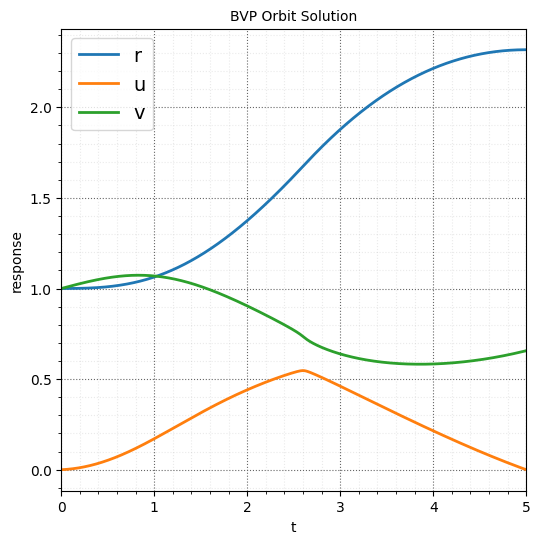

In [5]:
if res0.success:
    plt.figure(figsize = (6,6))
    plt.plot(res0.x,res0.y[0,:],label='r')
    plt.plot(res0.x,res0.y[1,:],label='u')
    plt.plot(res0.x,res0.y[2,:],label='v')
    plt.xlabel('t')
    plt.ylabel('response')
    plt.legend()
    plt.legend(fontsize=14)
    plt.xlim([0,Tf])

    plt.title('BVP Orbit Solution')
    nicegrid()
    plt.savefig('figs/bvp_orbit1.png')
    plt.show()

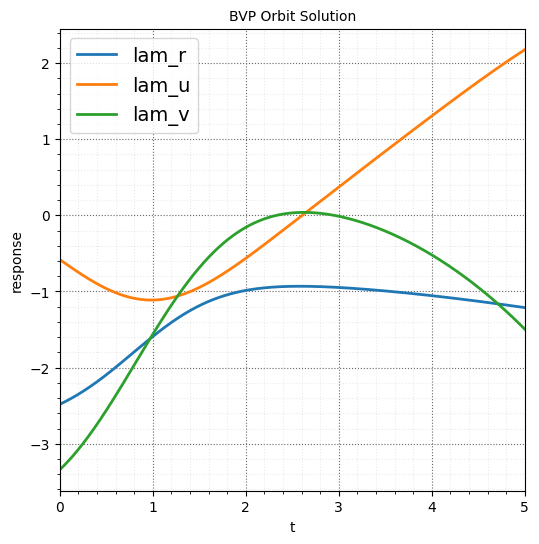

In [14]:
if res0.success:
    plt.figure(figsize = (6,6))
    plt.plot(res0.x,res0.y[3,:],label='lam_r')
    plt.plot(res0.x,res0.y[4,:],label='lam_u')
    plt.plot(res0.x,res0.y[5,:],label='lam_v')
    plt.xlabel('t')
    plt.ylabel('response')
    plt.legend()
    plt.legend(fontsize=14)
    plt.xlim([0,Tf])

    plt.title('BVP Orbit Solution')
    nicegrid()
    plt.savefig('figs/bvp_orbit1a.png')
    plt.show()


In [15]:
dt = np.diff(res0.x);
dth = (res0.y[2,:-1]/res0.y[0,:-1])*dt # \dot \theta = v_t/r
th = 0 + np.cumsum(dth)

In [16]:
pathloc=[res0.y[0,:-1]*np.cos(th), res0.y[0,:-1]*np.sin(th)];

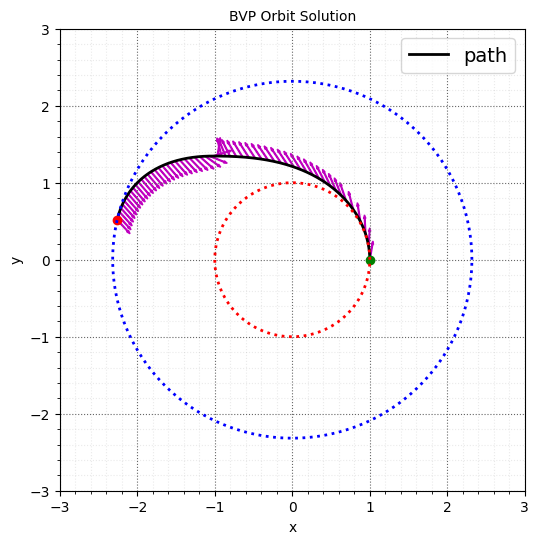

In [17]:
r0 = res0.y[0,0]
rf = res0.y[0,-1]

plt.figure(figsize = (6,6))
plt.plot(pathloc[0],pathloc[1],'k-',label='path')
plt.plot(r0,0,'go') # start
plt.plot(rf*np.cos(th[-1]),rf*np.sin(th[-1]),'ro') # stop

# make an orbit
ang = np.arange(0,2*np.pi-1e-10,.01)
zz = np.exp(complex(0,1)*ang);
plt.plot(r0*zz.real,r0*zz.imag,'r:')
plt.plot(rf*zz.real,rf*zz.imag,'b:')

#arrow(x, y, dx, dy, **kwargs)[source]
fact = 0.2
ang2 = np.arctan2(res0.y[4,:],res0.y[5,:]) + np.pi
ep = np.pi/2 + th - ang2[:-1]
xt = fact*np.cos(ep)
yt = fact*np.sin(ep);
for i in np.arange(0,th.shape[0],int(0.1*N)):
    plt.arrow(pathloc[0][i],pathloc[1][i],xt[i],yt[i],color='m',width=.01)

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.legend(fontsize=14)
plt.title('BVP Orbit Solution')
rr = math.ceil(rf+0.5)
plt.xlim([-rr,rr])
plt.ylim([-rr,rr])
nicegrid()

plt.savefig('figs/bvp_orbit2.png')
plt.show()

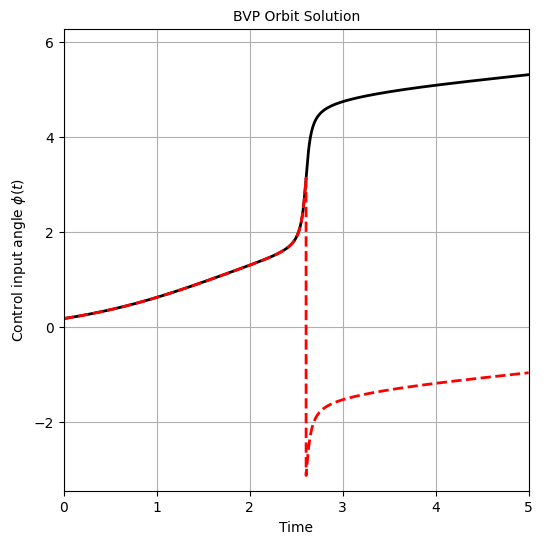

In [18]:
phi = ang2
phi = (phi + np.pi) % (2 * np.pi) - np.pi #https://stackoverflow.com/questions/15927755/opposite-of-numpy-unwrap/15927914

plt.figure(figsize = (6,6))
plt.plot(res0.x,ang2,'k-',label='$\phi$')
plt.plot(res0.x,phi,'r--',label='wrapped $\phi$')
plt.title('BVP Orbit Solution')
plt.xlabel('Time')
plt.ylabel(f'Control input angle $\phi(t)$')
plt.xlim([0,Tf])
plt.ylim([-1.1*np.pi,2*np.pi])
plt.savefig('figs/bvp_orbit3.png')
plt.show()

In [19]:
def fun_prop(t,xv):
    r = xv[0]
    u = xv[1]
    v = xv[2]
    
    if t <= Tf:
        phi = phi_plan(t)
        Tinp = np.copy(T)
    else:
        phi = 0.0
        Tinp = 0
    sinphi = np.sin(phi)
    cosphi = np.cos(phi)

    dr = u
    du = v**2/r - Mu/r**2 + Tinp*sinphi/(m0 + m1*t)
    dv = -u*v/r + Tinp*cosphi/(m0 + m1*t)

    return np.array([dr, du, dv])

X0 = np.array([R0, 0.0, np.sqrt(Mu/R0)])
N = 1000
t_plan = np.linspace(0, 2*Tf, N) # MPC plan time
phi_plan = interp1d(x = np.append(res0.x,2*Tf), y = np.append(phi,0.0), kind='zero')
res1 = solve_ivp(fun_prop, [0, 2*Tf], X0, rtol=1e-9, t_eval=t_plan)

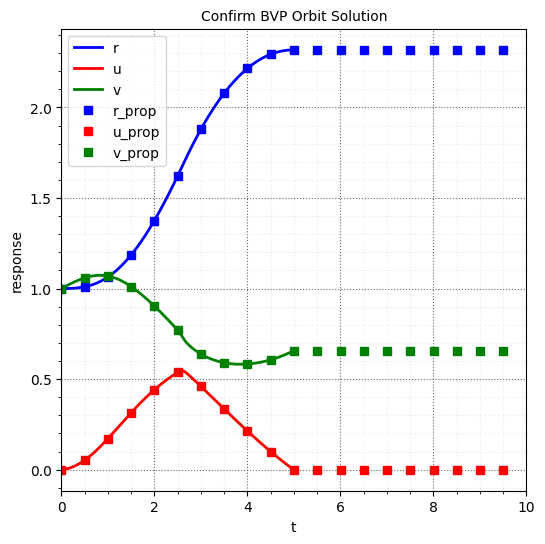

In [20]:
skip = int(0.05*N)
plt.figure(figsize = (6,6))
plt.plot(res0.x,res0.y[0,:],'b',label='r')
plt.plot(res0.x,res0.y[1,:],'r',label='u')
plt.plot(res0.x,res0.y[2,:],'g',label='v')
plt.plot(res1.t[::skip],res1.y[0,::skip],'bs',label='r_prop')
plt.plot(res1.t[::skip],res1.y[1,::skip],'rs',label='u_prop')
plt.plot(res1.t[::skip],res1.y[2,::skip],'gs',label='v_prop')
plt.xlabel('t')
plt.ylabel('response')
plt.legend()
plt.legend(fontsize=10)
plt.xlim([0,2*Tf])

plt.title('Confirm BVP Orbit Solution')
nicegrid()
plt.savefig('figs/bvp_orbit1b.png')
plt.show()